# Vanilla REINFORCE Algorithm Implementation
In the family of policy gradient methods, **REINFORCE** is one of the simplest and oldest algorithms. It introducing the basic concept of updating policies using gradient ascent on the expected reward.

REINFORCE is a Monte Carlo policy gradient method. It updates the policy parameters by taking steps proportional to the gradient of the expected return.  
In this notebook, we will implement the vanilla REINFORCE algorithm and apply it to a grid environment which the goal is moving from a random starting point to the desired goal position.

## References
- Simple Statistical Gradient-Following Algorithms for Connectionist Reinforcement Learning, [https://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf](https://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf), Ronald J. Williams, 1992.

In [1]:
import torch
import torch.nn as nn
from torch import nn, optim
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
from ignite.handlers import ModelCheckpoint
from ignite.contrib.handlers import TensorboardLogger, global_step_from_engine
import numpy as np
from torchvision import transforms
import gymnasium
from PIL import Image

from IPython import display
from typing import List, Tuple, NamedTuple

from commons import *
from rl_envs import SimpleGridEnv

/Users/h-alice/Documents/Projects/rl-test/.venv/lib/python3.12/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


## Initialization

This notebook is run and tested with Python 3.12 on a MacBook M2 Pro with MPS acceleration enabled.

In [2]:
device = "mps" # Hello, MacBooks ;)

## Environment
The environment is a simple grid environment, which objective is to reach the goal block. The agent can move in four directions: up, down, left, and right.

The observation space is a vestor $v\in\Reals^4$, where $v = [x, y, x_{goal}, y_{goal}]$.

The action space is a probability distribution over the four directions $\mathcal{A} = \{0, 1, 2, 3\}$, which 0 indicates up, 1 indicates down, 2 indicates left, and 3 indicates right, respectively.

We also implemented a simple rendering function to visualize current state and the agent's action.  
In the rendered state, The red block indicates the agent, the green block indicates the goal, and the dark blue block indicates the track of the agent.


(array([2, 0, 2, 1]), -0.1, False, {'history': [array([2, 1])]})
(array([3, 0, 2, 1]), -0.1, False, {'history': [array([2, 1]), array([2, 0])]})
(array([3, 1, 2, 1]), -0.1, False, {'history': [array([2, 1]), array([2, 0]), array([3, 0])]})
(array([3, 2, 2, 1]), -0.1, False, {'history': [array([2, 1]), array([2, 0]), array([3, 0]), array([3, 1])]})
(array([3, 1, 2, 1]), -0.1, False, {'history': [array([2, 1]), array([2, 0]), array([3, 0]), array([3, 1]), array([3, 2])]})


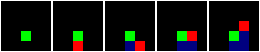

In [3]:
# Simple rollout
gr = SimpleGridEnv(5)
_images = []
gr.reset()
for _ in range(5):
    _images.append(gr.render(pixel_size=10, with_history=True))
    print(obs := gr.step(np.random.randint(0, 4)))
    if obs[2]:
        _images.append(gr.render(pixel_size=10, with_history=True))
        break

display.display(Image.fromarray(stack_images(_images)))

## Trajectory
A **trajectory entry $\tau$** stores:
- observation aka state $s_t\in\mathcal{S}$
- action $a_t\in\mathcal{A}$
- reward $r_t\in\Reals$
- done flag $d_t\in\{0,1\}$
- log probability of the action $\log\pi{_\theta}(a_t|s_t)$

And a **trajectory** is a sequence of trajectory entries.

In [4]:
class TrajectoryEntry(NamedTuple):
    observe: np.ndarray
    action: int
    reward: float
    done: bool
    log_prob: torch.Tensor

type Trajectory = List[TrajectoryEntry]

Trajectory generation part is yet simple, which follows the steps:
1. Reset the environment and get the initial observation.
2. Get the action distribution from the policy network, also storge the log probability for optimization.
3. Take an action and get the next observation, reward, and done flag.
4. Store the trajectory entry and repeat the steps 2-3 until the done flag is set or the maximum steps are reached.

In [5]:
def generate_trajectory(env: gymnasium.Env, policy: torch.nn.Module, /, max_episode_length=100):
    obs = env.reset()
    done = False
    ep_counter = 0

    trajectory: Trajectory = []

    while not done:
        ep_counter += 1
        action_prob = nn.Softmax(dim=-1)(policy(torch.tensor(obs).float().to(device)))
        action = np.random.choice(np.arange(4), p=action_prob.detach().to("cpu").numpy())
        obs, reward, done, _ = env.step(action)
        trajectory.append(TrajectoryEntry(observe=obs, action=action, reward=reward, done=done, log_prob=torch.log(action_prob[action])))

        if ep_counter >= max_episode_length:
            break

    return trajectory

# Policy Network
The policy network is a simple feedforward neural network with two hidden layers. The input is the observation vector $v$ and the output is a probability distribution over the action space $\mathcal{A}$.

We use SELU activation function for the hidden layers to achieve self-normalization manner.

In [6]:
class Policy(nn.Module):
    def __init__(self, activation=nn.SELU()):
        super().__init__()
        self.activation = activation
        self.fc = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        x = self.fc(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

# Optimization with REINFORCE

Here comes the final part, the optimization with REINFORCE algorithm.

We basicly follows the definition of the REINFORCE algorithm:

$$
\theta_{new} \leftarrow \theta_{old} + \alpha\nabla{\pi{_\theta}{\ln{(a|s)}}}
$$

Which there's a ittle difference, we accumulate the gradients and apply the update after the trajectory is done.

In [7]:
p = Policy().to(device) # Policy network
optimizer = optim.Adam(p.parameters(), lr=0.0001)  # Optimizer, we've tried lr=0.001 and it failed miserably.

In [8]:
gr = SimpleGridEnv(5)
for _ in range(10000): # 10000 epochs.
    p.train()
    p.zero_grad()
    reward_gamma = 0.99
    cumulated_reward = 0
    traj = generate_trajectory(gr, p, max_episode_length=100)
    for index, step in enumerate(traj):
        cumulated_reward = cumulated_reward + step.reward * (reward_gamma ** index)
        objective = step.log_prob * cumulated_reward
        objective *= -1 # Optimizing -1 * reward with gradient descent = optimizing reward with gradient ascent
        objective.backward(retain_graph=True)
    
    optimizer.step()
    print(f'Current reward: {cumulated_reward:.2f}, Current episode length: {len(traj)}      ', sep=' ', end='\r') # We put extra whitespaces to overwrite the previous line.


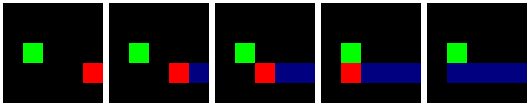

In [11]:
p.eval()
gr = SimpleGridEnv(5)
done = False
images = []
obs = gr.reset()

images.append(gr.render(pixel_size=20, with_history=True)) # Initial state
while not done:
    action_prob = nn.Softmax(dim=-1)(p(torch.tensor(obs).float().to(device)))
    action = np.random.choice(np.arange(4), p=action_prob.detach().to("cpu").numpy())
    obs, reward, done, _ = gr.step(action)
    images.append(gr.render(pixel_size=20, with_history=True))


display.display(Image.fromarray(stack_images(images, border_thickness=3, border_color=[255, 255, 255])))